In [4]:
import requests
import geopandas as gpd
import pandas as pd

In [67]:


base_url = "https://apps.fs.usda.gov/arcx/rest/services/EDW/EDW_MTBS_01/MapServer/63/query"

def fetch_data(start_year, end_year, offset=0, limit=1000):
    params = {
        'where': f'YEAR>={start_year} AND YEAR<={end_year}',
        'outFields': 'FIRE_ID,FIRE_NAME,YEAR,ACRES',
        'returnGeometry': 'false',
        'outSR': 4326,
        'f': 'json',
        'resultRecordCount': limit,
        'resultOffset': offset
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    
    if 'features' in data and len(data['features']) > 0:
        records = [feature['attributes'] for feature in data['features']]
        return pd.DataFrame(records)
    else:
        return pd.DataFrame()  # Return an empty DataFrame if no records are found

# Initialize an empty DataFrame to store all records
ten_years_records = pd.DataFrame()

# Fetch data in smaller chunks
years = [(2012, 2013), (2014, 2016), (2017, 2019), (2020, 2024)]
for start_year, end_year in years:
    offset = 0
    while True:
        df = fetch_data(start_year, end_year, offset)
        if not df.empty:
            ten_years_records = pd.concat([ten_years_records, df], ignore_index=True)
            offset += 1000  # Move to the next batch
        else:
            break  # Exit loop if no more data

# Display the DataFrame
print(ten_years_records)



                    FIRE_ID         FIRE_NAME  YEAR    ACRES
0     FL2845808085120130112       FLORA VISTA  2013    889.0
1     FL2929308118020130302     DURRANCE FIRE  2013   1245.0
2     FL2818808080420130316  OPENING DAY FIRE  2013    702.0
3     FL2810908116820130326  WAGON WHEEL FIRE  2013    875.0
4     FL2846408065320130401            CENTER  2013   2237.0
...                     ...               ...   ...      ...
9816  MT4485811343720200811        BEAR CREEK  2020  14978.0
9817  CA3702412151420200705             CREWS  2020   5802.0
9818  SC3297807985820200229          C-113 FM  2020    939.0
9819  AL3103008683320201017  CN ROCK CREEK 05  2020   1105.0
9820  FL2862308067720200715   FMU 5.1 C AND D  2020    914.0

[9821 rows x 4 columns]


In [68]:
unique_years = ten_years_records['YEAR'].unique()
print("Unique years in the DataFrame:")
print(sorted(unique_years))

Unique years in the DataFrame:
[2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


In [70]:
ten_years_records.head()
# Assuming `all_records` is your DataFrame
csv_file_path = 'Output_Data/all_fires_2012_2022.csv'

# Save the DataFrame to a CSV file
ten_years_records.to_csv(csv_file_path, index=False)

print(f"DataFrame has been saved to {csv_file_path}")
ten_years_records

DataFrame has been saved to Output_Data/all_fires_2012_2022.csv


,FIRE_ID,FIRE_NAME,YEAR,ACRES
0,FL2845808085120130112,FLORA VISTA,2013,889.0
1,FL2929308118020130302,DURRANCE FIRE,2013,1245.0
2,FL2818808080420130316,OPENING DAY FIRE,2013,702.0
3,FL2810908116820130326,WAGON WHEEL FIRE,2013,875.0
4,FL2846408065320130401,CENTER,2013,2237.0
...,...,...,...,...
9816,MT4485811343720200811,BEAR CREEK,2020,14978.0
9817,CA3702412151420200705,CREWS,2020,5802.0
9818,SC3297807985820200229,C-113 FM,2020,939.0
9819,AL3103008683320201017,CN ROCK CREEK 05,2020,1105.0


In [5]:
import requests
import pandas as pd

# Base URL for the API
base_url = "https://apps.fs.usda.gov/arcx/rest/services/EDW/EDW_MTBS_01/MapServer/63/query"

def fetch_data(years, lat_min, lat_max, lon_min, lon_max, offset=0, limit=1000):
    # Create a where clause to include only specific years
    year_filter = " OR ".join([f"YEAR={year}" for year in years])
    params = {
        'where': year_filter,
        'outFields': 'FIRE_ID,FIRE_NAME,YEAR,ACRES',
        'returnGeometry': 'true',
        'outSR': 4326,
        'f': 'json',
        'resultRecordCount': limit,
        'resultOffset': offset,
        'geometry': f'{{"xmin":{lon_min},"ymin":{lat_min},"xmax":{lon_max},"ymax":{lat_max}}}',
        'geometryType': 'esriGeometryEnvelope',
        'spatialRel': 'esriSpatialRelIntersects'
    }
    try:
        response = requests.get(base_url, params=params)
        response.raise_for_status()  # Raise an HTTPError for bad responses
        data = response.json()
        
        if 'features' in data and len(data['features']) > 0:
            records = []
            for feature in data['features']:
                attrs = feature['attributes']
                # Extract geometry coordinates (assuming polygons)
                geometry = feature.get('geometry', {})
                if geometry.get('rings'):
                    # Assuming the first ring is the main polygon outline
                    coordinates = geometry['rings'][0]
                    # Take the average coordinate as a representative point
                    if coordinates:
                        avg_lat = sum([point[1] for point in coordinates]) / len(coordinates)
                        avg_lon = sum([point[0] for point in coordinates]) / len(coordinates)
                        attrs['latitude'] = avg_lat
                        attrs['longitude'] = avg_lon
                records.append(attrs)
            return pd.DataFrame(records)
        else:
            return pd.DataFrame()  # Return an empty DataFrame if no records are found
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data: {e}")
        return pd.DataFrame()  # Return an empty DataFrame on error

# Define bounding box coordinates for California
lat_min = 32.5343  # Southern border
lat_max = 42.0095  # Northern border
lon_min = -124.8489 # Western border
lon_max = -118.5 # Eastern border

# Initialize an empty DataFrame to store all records
all_records = pd.DataFrame()

# Fetch data for the years 1985 and 1997
years = [1985, 1997]
offset = 0
limit = 1000  # API limit

while True:
    df = fetch_data(years, lat_min, lat_max, lon_min, lon_max, offset, limit)
    if not df.empty:
        all_records = pd.concat([all_records, df], ignore_index=True)
        offset += limit  # Move to the next batch
    else:
        break  # Exit loop if no more data

# Display the DataFrame
print(all_records.head())
print(f"Total records fetched: {len(all_records)}")
all_records.head()

                 FIRE_ID   FIRE_NAME  YEAR    ACRES   latitude   longitude
0  CA3601111879719850712    TULARE 4  1985   1290.0  36.010690 -118.797118
1  CA3544311877719850503    ADELAIDE  1985   1054.0  35.442899 -118.775606
2  CA3672712076819850609   PONOCHE 2  1985   7508.0  36.731401 -120.766906
3  CA3590312056319850702       LOWES  1985   2708.0  35.904321 -120.565786
4  CA3637912058319850706  LOSGATOSIV  1985  20357.0  36.382287 -120.581746
Total records fetched: 109


,FIRE_ID,FIRE_NAME,YEAR,ACRES,latitude,longitude
0,CA3601111879719850712,TULARE 4,1985,1290.0,36.010690,-118.797118
1,CA3544311877719850503,ADELAIDE,1985,1054.0,35.442899,-118.775606
2,CA3672712076819850609,PONOCHE 2,1985,7508.0,36.731401,-120.766906
3,CA3590312056319850702,LOWES,1985,2708.0,35.904321,-120.565786
4,CA3637912058319850706,LOSGATOSIV,1985,20357.0,36.382287,-120.581746


In [6]:
# Count the number of records for each year
year_counts = all_records['YEAR'].value_counts().sort_index()
print("Count of records for each year:")
print(year_counts)

Count of records for each year:
YEAR
1985    76
1997    33
Name: count, dtype: int64


In [7]:
# Assuming `all_records` is your DataFrame
csv_file_path = 'Output_Data/california_data_1985_1997.csv'

# Save the DataFrame to a CSV file
all_records.to_csv(csv_file_path, index=False)

print(f"DataFrame has been saved to {csv_file_path}")


DataFrame has been saved to Output_Data/california_data_1985_1997.csv


In [10]:
import folium
import plotly.express as px

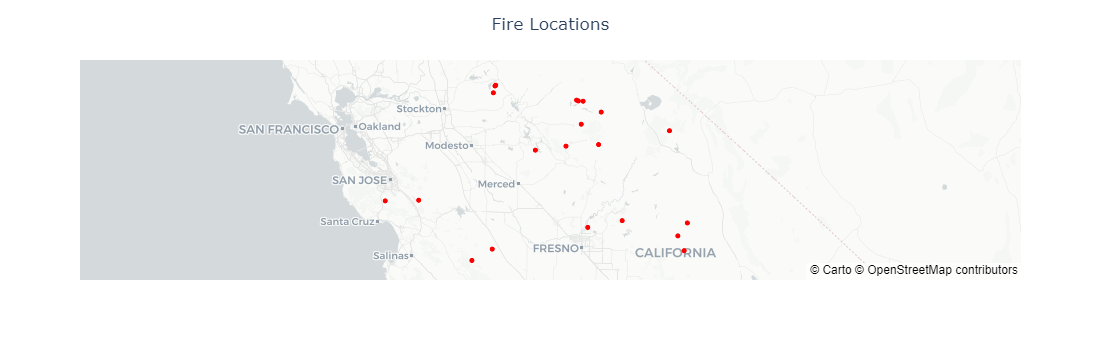

Plotly map has been saved to 'california_map_plotly.html'


In [12]:
all_records = pd.read_csv('Output_Data/california_data_1985_1997.csv')

# Create a scatter mapbox plot
fig = px.scatter_mapbox(
    all_records,
    lat='latitude',
    lon='longitude',
    hover_name='FIRE_NAME',
    hover_data={'YEAR': True, 'ACRES': True},
    color_discrete_sequence=['red'],
    zoom=6,
    mapbox_style="carto-positron"
)

# Update layout to show title
fig.update_layout(
    title='Fire Locations',
    title_x=0.5
)

# Save to HTML
fig.write_html('Output_Data/california_map_plotly_1985_1997.html')
fig.show()
print("Plotly map has been saved to 'california_map_plotly.html'")

In [49]:
from IPython.display import display
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt


In [50]:
# Assuming `all_records` DataFrame has latitude and longitude columns
# Create a GeoDataFrame
geometry = [Point(xy) for xy in zip(all_records['longitude'], all_records['latitude'])]
gdf = gpd.GeoDataFrame(all_records, geometry=geometry)

# Set the coordinate reference system (CRS) to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Display the first few records
gdf.head()

,FIRE_ID,FIRE_NAME,YEAR,ACRES,latitude,longitude,geometry
0,CA3633311865120220803,SUMMIT,2022,2266.0,36.329019,-118.655495,POINT (-118.65550 36.32902)
1,CA3766111947120220804,RED,2022,8495.0,37.663513,-119.488056,POINT (-119.48806 37.66351)
2,CA3754911992120220722,OAK,2022,19408.0,37.545651,-119.861742,POINT (-119.86174 37.54565)
3,CA3831412072120220704,ELECTRA,2022,4645.0,38.337929,-120.653866,POINT (-120.65387 38.33793)
4,CA3750011961420220707,WASHBURN,2022,4980.0,37.521986,-119.581364,POINT (-119.58136 37.52199)


<Axes: >

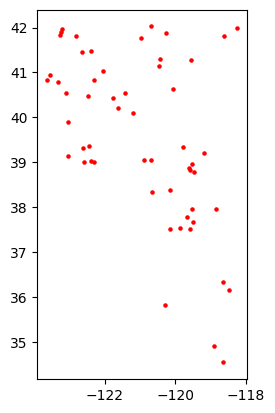

In [51]:
# Plot the fire locations
gdf.plot(marker='o', color='red', markersize=5)

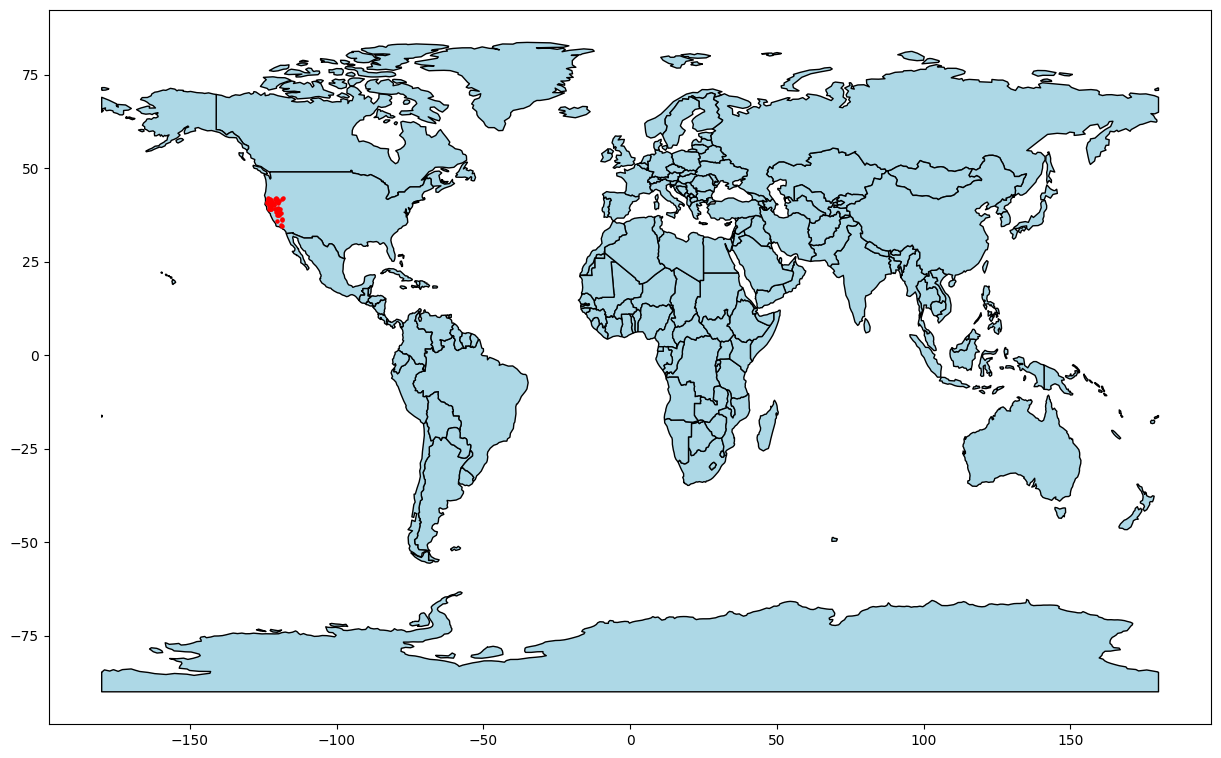

In [52]:
# Convert your latitude and longitude data into Point geometries
geometry = [Point(xy) for xy in zip(all_records['longitude'], all_records['latitude'])]

# Create a GeoDataFrame from your data
gdf = gpd.GeoDataFrame(all_records, geometry=geometry)

# Set the coordinate reference system to WGS84 (EPSG:4326)
gdf.set_crs(epsg=4326, inplace=True)

# Plot the world map
ax = world.plot(figsize=(15, 10), color='lightblue', edgecolor='black')

# Plot your data points on the map
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

# Show the plot
plt.show()


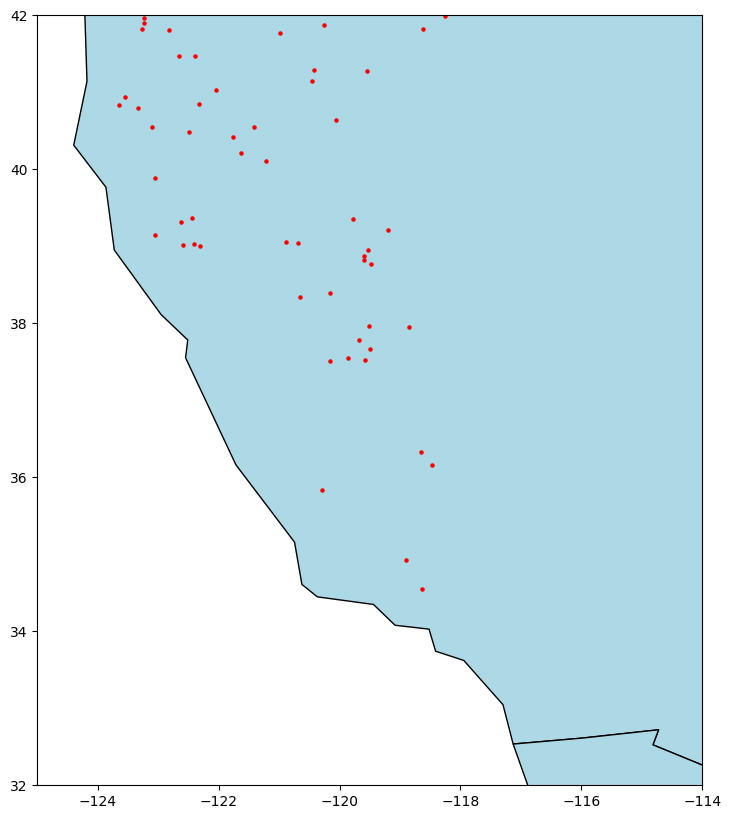

In [53]:
# Plot the world map
ax = world.plot(figsize=(15, 10), color='lightblue', edgecolor='black')

# Plot your data points on the map
gdf.plot(ax=ax, marker='o', color='red', markersize=5)

# Set the bounding box (for California, for example)
plt.xlim([-125, -114])  # Longitude range
plt.ylim([32, 42])      # Latitude range

# Show the plot
plt.show()
